In [1]:
from nutils import*
import numpy as np
import vtk
import image_based_analysis as im

In [2]:
class MaterialModel:
    def __init__(self, tissue_label, E_map, nu_map):
        self.tissue_label = tissue_label
        new_E_map = {}
        new_nu_map = {}
        for key in E_map:
            new_E_map[tissue_label[key]] = E_map[key]
        for key in nu_map:
            new_nu_map[tissue_label[key]] = nu_map[key]
        self.E_map = im.IM_LabelMap(new_E_map)
        self.nu_map = im.IM_LabelMap(new_nu_map)
    def E(self, key):
        return self.E_map[self.tissue_label[key]]
    def nu(self, key):
        return self.nu_map[self.tissue_label[key]]

class BackgroundLabel(function.Array):
    @types.apply_annotations
    def __init__(self, material_model, air_threshold, *args:function.asarrays):
        self.air_threshold = air_threshold
        self.material_model = material_model
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=float)
    
    def CalculateLabel(self, hu):
        if hu <= self.air_threshold:
            return self.material_model.tissue_label["air"]
        else:
            return self.material_model.tissue_label["heart"]
    def evalf(self, hu_vals):
        return np.array([self.CalculateLabel(hu) for hu in hu_vals])

class ArteryLabel(function.Array):
    @types.apply_annotations
    def __init__(self, material_model, artery_threshold, *args:function.asarrays):
        self.material_model = material_model
        self.artery_threshold = artery_threshold
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=float)
    
    def CalculateLabel(self, b, v):
        if v <= self.artery_threshold:
            return self.material_model.tissue_label["artery"]
        else:
            return b
    def evalf(self, background, wall_sdf):
        return np.array([self.CalculateLabel(b, v) for b, v in zip(background, wall_sdf)])

class AutoplaqueLabel(function.Array):
    @types.apply_annotations
    def __init__(self, material_model, null_label, *args:function.asarrays):
        self.material_model = material_model
        self.null_label = null_label
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=float)
    
    def CalculateLabel(self, b, a):
        if a == self.null_label:
            return b
        else:
            return a
    
    def evalf(self, background, autoplaque):
        return np.array([self.CalculateLabel(b, a) for b, a in zip(background, autoplaque)])   
        
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)    

def ScaleTissueMap(tissue_map):
    scaled_tissue_map = {}
    i = 0
    for key in tissue_map:
        scaled_tissue_map[tissue_map[key]] = i
        i+=1
    return im.IM_LabelMap(scaled_tissue_map)

class IM_AABB:
    def __init__(self, position, size):
        self.position = position
        self.size = size
    def ContainsPoint(self, pt):
        return np.all(np.logical_and(0 <= pt - self.position,  pt - self.position <= self.size))
    def ToMesh(self, shape):
        return Rectilinear(self.position, self.position + self.size, shape)
    def Volume(self):
        return np.product(self.size)
    def Center(self):
        return self.position + self.size / 2
    def Verts(self):
        a = self.position
        b = self.position + size[2]
        c = self.position + size[1]
        d = self.position + size[1] + size[2]
        e = self.position + size[0]
        f = self.position + size[2] + size[0]
        g = self.position + size[1] + size[0]
        h = self.position + size[1] + size[2] + size[0]
    def WorldToLocal(self, pt):
        return (pt - self.position) / self.size
    def LocalToWorld(self, pt):
        return pt * size + self.position
    
def RotationMatrix(axis, theta):
    c = np.cos(theta)
    s = np.sin(theta)
    R1 = np.array([c + axis[0]**2 * (1 - c) , axis[0] * axis[1] * (1 - c) - axis[2] * s, axis[0] * axis[2] * (1 - c) + axis[1] * s])
    R2 = np.array([axis[0] * axis[1] * (1 - c) + axis[2] * s , axis[1]**2 * (1 - c) + c, axis[1] * axis[2] * (1 - c) - axis[0] * s])
    R3 = np.array([axis[0] * axis[2] * (1 - c) - axis[1] * s , axis[1] * axis[2] * (1 - c) + axis[0] * s, axis[2]**2 * (1 - c) + c])
    return np.array([R1, R2, R3])

def PlaneRotationMatrix():
    xrot = np.array([[1,0,0],[0,np.cos(angles[0]), -np.sin(angles[0])],[0,np.sin(angles[0]), np.cos(angles[0])]])
    yrot = np.array([[np.cos(angles[1]), 0, -np.sin(angles[1])],[0,1,0], [np.sin(angles[1]), 0, np.cos(angles[1])]])
    zrot = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0],[np.sin(angles[2]), np.cos(angles[2]), 0], [0,0,1]])
    return zrot.dot(yrot.dot(xrot))

def GetParaviewBoxTransformationMatrix(angles):
    xrot = np.array([[1,0,0],[0,np.cos(angles[0]), -np.sin(angles[0])],[0,np.sin(angles[0]), np.cos(angles[0])]])
    ny = xrot.dot(np.array([0,1,0]))
    yrot = RotationMatrix(ny, angles[1])
    zrot = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0],[np.sin(angles[2]), np.cos(angles[2]), 0], [0,0,1]])
    return zrot.dot(yrot.dot(xrot))

class IM_TightBB:
    def __init__(self, position, size, M):
        self.position = position
        self.size = size
        self.M = M
    def Verts(self):
        axes = self.M.dot(np.diag(self.size)).transpose()
        a = self.position
        b = self.position + axes[2]
        c = self.position + axes[1]
        d = self.position + axes[1] + axes[2]
        e = self.position + axes[0]
        f = self.position + axes[2] + axes[0]
        g = self.position + axes[1] + axes[0]
        h = self.position + axes[1] + axes[2] + axes[0]
        return np.array([a,b,c,d,e,f,g,h])        
    def GetAABB(self):
        verts = self.Verts()
        min_bounds = np.min(verts, axis=0)
        max_bounds = np.max(verts, axis=0)
        return IM_AABB(min_bounds, max_bounds - min_bounds)
    def ContainsPoint(self, pt):
        p = self.M.transpose().dot(pt - self.position)
        return np.all(np.logical_and(0 <= p, p <= self.size))
    def ToMesh(self, shape):
        axes = self.M * np.diag(self.size)
        ns = function.Namespace()
        topo, ns.xi = im.Rectilinear(np.zeros([3]), self.size, shape)
        ns.M = function.asarray(self.M)
        ns.origin = function.asarray(self.position)
        ns.x_i = 'M_ij xi_j + origin_i'
        return topo, ns.xi, ns.x
    def Volume(self):
        return np.product(self.size)
    def Center(self):
        return np.mean(self.Verts(), axis=0)
    def WorldToLocal(self, pt):
        return self.M.dot(pt - self.position) / self.size
    def LocalToWorld(self, pt):
        return self.M.transpose().dot(pt * size) + self.position

def RefineVoxelMeshByTolerance(topo, f, nrefine, tol):
    dim = topo.ndims
    refined_topo = topo
    for n in range(nrefine):
        elems_to_refine = []
        k = 0
        bez = refined_topo.sample('bezier',2)
        vals = bez.eval(f)
        vals = vals.reshape( [len(vals)//2**dim, 2**dim] )
        for i in range(len(vals)):
            if np.any(abs(vals[i,:]) < tol):
                elems_to_refine.append(k)
            k = k + 1
        if len(elems_to_refine) != 0:
            refined_topo = refined_topo.refined_by(refined_topo.transforms[np.array(elems_to_refine)])
    return refined_topo

def GetAffineTransformation(structured_topo, geom):
    nelems = len(structured_topo)
    shape = structured_topo.shape
    dim = structured_topo.ndims
    ielems = np.array([0,nelems-1],dtype=int)
    xis = np.array([np.zeros([dim]), np.ones([dim])],dtype=float)
    corner_sample = structured_topo._sample(ielems, xis)
    corners = corner_sample.eval(geom)
    geom0 = corners[0]
    scale = (corners[1] - corners[0]) / shape
    return geom0, scale

def LocateSampleOnLinearMesh(fromsample, fromgeom, totopo, togeom, eps=0, **kwargs):
    geom0, scale = im.GetAffineTransformation(totopo, togeom)
    print(geom0)
    print(scale)
    coords = fromsample.eval(fromgeom)
    weights = im.GetWeights(fromsample)
    return totopo._locate(geom0, scale, coords, eps=eps, weights=weights)

In [3]:
# INPUTS

# Set data paths
lumen_flow_sim_path = "data/flow_sim.vtu"
autoplaque_img_path = "data/autoplaque.mha"
wallsdf_img_path = "data/outer_wall.mha"
hu_img_path = "data/hu.mha"

# Define Material Model
tissue_map = {"air" : 1, "blood" : -1 , "heart" : 0, "artery" : 33, "fibrous" : 75, "calcified" : 225}
nu_map = {"air" : 0, "blood" : 0, "heart" : 0.4, "artery" : 0.27, "fibrous" : 0.27, "calcified" : .31}
E_map = {"air" : 1e-4, "blood" : 2 / 1000, "heart" : 60 / 1000, "artery" : 100 / 1000, "fibrous" : 1000 / 1000, "calcified" : 10000 / 1000}

# Define Material properties projection degree
p_conv = 1

# Define Region of Interest
position = (39.35025102748692, -182.88678578819045, 635.1077093084257)
U = np.array([1,0,0])
V = np.array([0,1,0])
W = np.array([0,0,1])

# Define Mesh size
Nu = 3
Nv = 3
Nw = 3

# Define refinement scheme
nref = 1
delta = 1/5
nqref = 1

# Define basis degree
p = 2

# Define stiffness Quadrature Rule
q = 3

# Define Immersed Boundary Quadrature Rule
qu = 20

# Define post processing projection degree
p_post = 1

# Define Export parameters
plots = ["disp_smooth", "vonmises_smooth"]
res = 3

In [4]:
# Process Inputs

# Build Mesh
lumen_mesh = im.ReadVTKMesh(lumen_flow_sim_path)

# Build Images
autoplaque_img = im.IM_Image_CreateFromVTKMetaImageFile(autoplaque_img_path)
wallsdf_img = im.IM_Image_CreateFromVTKMetaImageFile(wallsdf_img_path)
hu_img = im.IM_Image_CreateFromVTKMetaImageFile(hu_img_path)

# Build Material Model
material_model = MaterialModel(tissue_map, E_map, nu_map)

In [5]:
# Build Immersed Lumen mesh, Gamma

# construct lumen ROI bounding box
position = np.array([46.80474441461811,-189.58819670192366,636.9385220611223])
rotation = np.pi / 180 * np.array([-6.63176249753866, -140.30783608141263, 26.96745476126069])
size = np.array([4.380050382199371, 12.324963385845773, 3.76428591221843])
M = GetParaviewBoxTransformationMatrix(rotation)
lumen_bb = IM_TightBB(position, size, M)

# convert vtk mesh to trimesh
lumen_tri_mesh = im.IM_TriMesh_CreateFromVTKMesh(lumen_mesh, data_keys={"Traction", "normal"})

# Trim Lumen mesh by bounding volume
lumen_tri_mesh.TrimByBoundingBox(lumen_bb)

# convert trimesh to nutils mesh
gamma = function.Namespace()
gamma_topo, gamma.x = lumen_tri_mesh.ToMesh()

# build traction and normal functions
gamma.linbasis = gamma_topo.basis('spline',1)
normals = lumen_tri_mesh.GetData("normal")
gamma.Nx = gamma.linbasis.dot(normals[:,0])
gamma.Ny = gamma.linbasis.dot(normals[:,1])
gamma.Nz = gamma.linbasis.dot(normals[:,2])
gamma.N_i = '<Nx, Ny, Nz>_i'
tractions = lumen_tri_mesh.GetData("Traction")
gamma.Tx = gamma.linbasis.dot(tractions[:,0])
gamma.Ty = gamma.linbasis.dot(tractions[:,1])
gamma.Tz = gamma.linbasis.dot(tractions[:,2])
gamma.T_i = '<Tx, Ty, Tz>_i'

In [6]:
# verify gamma
bez = gamma_topo.sample('bezier', 2)
xvals = bez.eval(gamma.x)
export.vtk("gamma_test", bez.tri, xvals)

gamma_test.vtk


In [6]:
# Build Analysis Mesh, Omega

# scale lumen ROI box
scale = [2,1.1,2]
scaled_size = lumen_bb.size * scale
scaled_position = lumen_bb.position - M.dot((scaled_size - lumen_bb.size) / 2)
omega_bb = IM_TightBB(scaled_position, scaled_size, lumen_bb.M)

# build mesh
omega = function.Namespace()
omega_topo, omega.xi, omega.x = omega_bb.ToMesh([Nu, Nv, Nw])

In [8]:
# verify omega
bez = omega_topo.sample('bezier', 2)
xvals = bez.eval(omega.x)
export.vtk("omega_test", bez.tri, xvals)

omega_test.vtk


In [ ]:
# verify rotated omega
bez = omega_topo.sample('bezier', 2)
xvals = bez.eval(omega.xi)
export.vtk("rotated_omega_test", bez.tri, xvals)

In [7]:
# build rotated coordinates
gamma.M = function.asarray(M)
gamma.pos = function.asarray(omega_bb.position)
gamma.xi_i = 'M_ji (x_j - pos_j)'

In [11]:
# verify gamma rotated
bez = gamma_topo.sample('bezier', 2)
xvals = bez.eval(gamma.xi)
export.vtk("rotated_gamma_test", bez.tri, xvals)

rotated_gamma_test.vtk


In [8]:
# Build Autoplaque Image Mesh, Alpha

# Calculate AABB for analysis mesh
aabb = omega_bb.GetAABB()

# Extract subregion of autoplaque image
alpha = function.Namespace()
min_voxel_coords = autoplaque_img.VoxelCoordinates(aabb.position)
max_voxel_coords = autoplaque_img.VoxelCoordinates(aabb.position + aabb.size)
autoplaque_subimg = autoplaque_img.SubImage(min_voxel_coords, max_voxel_coords)

# convert to mesh
alpha_topo, alpha.x = autoplaque_subimg.ToMesh()

# build rotated coordinates
alpha.M = function.asarray(M)
alpha.xi_i = 'M_ji x_j'

In [16]:
# Construct material property functions on Alpha

# Convert Images to Functions
alpha.A = im.VoxelImageFunction(autoplaque_subimg, alpha.x[0], alpha.x[1], alpha.x[2])
alpha.W = im.BilinearVoxelImageFunction(wallsdf_img, alpha.x[0], alpha.x[1], alpha.x[2])
alpha.HU = im.BilinearVoxelImageFunction(hu_img, alpha.x[0], alpha.x[1], alpha.x[2])

# build material properties label function in 3d
air_threshold = -200
artery_threshold = 0
null_label = 0
alpha.Bg = BackgroundLabel(material_model, air_threshold, alpha.HU)
alpha.Artery = ArteryLabel(material_model, artery_threshold, alpha.Bg, alpha.W)
alpha.L0 = AutoplaqueLabel(material_model, null_label, alpha.Artery, alpha.A)

# build scaled representation
scaled_tissue_map = ScaleTissueMap(material_model.tissue_label)
alpha.Ls0 = im.LabelMapFunc(scaled_tissue_map, alpha.L0)

# Create Label Map Functions for Material Properties
alpha.nu0 = im.LabelMapFunc(material_model.nu_map, alpha.L0)
alpha.E0 = im.LabelMapFunc(material_model.E_map, alpha.L0)

# Define Lame Parameters
alpha.mu0 = 'E0 / (2 (1 + nu0))'
alpha.lmbda0 = 'E0 nu0 / ( (1 + nu0) (1 - 2 nu0) )'

# project material properties
alpha.convbasis = alpha_topo.basis('spline', p_conv)
alpha.mu = alpha_topo.projection(alpha.mu0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.lmbda = alpha_topo.projection(alpha.lmbda0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.E = alpha_topo.projection(alpha.E0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.nu = alpha_topo.projection(alpha.nu0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
alpha.Ls = alpha_topo.projection(alpha.Ls0, onto=alpha.convbasis, geometry=alpha.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))

project > constrained 51680/51680 dofs
project > constrained 51680/51680 dofs
project > constrained 51680/51680 dofs
project > constrained 51680/51680 dofs
project > constrained 51680/51680 dofs


In [10]:
# verify alpha
bez = alpha_topo.sample('bezier', 5)
xvals = bez.eval(alpha.x)
Ls0vals = bez.eval(alpha.Ls0)
Lsvals = bez.eval(alpha.Ls)
export.vtk("alpha_test", bez.tri, xvals, Ls0=Ls0vals, Ls=Lsvals)

alpha_test.vtk


In [9]:
# Refine Mesh and Quadrature

# create distance field for lumen mesh
omega.D = im.DistanceFromTriMesh(lumen_tri_mesh, omega.x[0], omega.x[1], omega.x[2])

# refine background topology for basis
refined_omega_topo = RefineVoxelMeshByTolerance(omega_topo, omega.D, nref, delta)
omega.basis = refined_omega_topo.basis('th-spline', degree = p)

# refine background topology for quadrature rule
refined_quadrature_topo = RefineVoxelMeshByTolerance(refined_omega_topo, omega.D, nref, delta)

In [16]:
# verify omega refined
print(len(omega_topo))
print(len(refined_omega_topo))
print(len(refined_quadrature_topo))
bez = refined_omega_topo.sample('bezier', 2)
xvals = bez.eval(omega.x)
export.vtk("refined_omega_test", bez.tri, xvals)

1000
1791
5753
refined_omega_test.vtk


In [14]:
# Construct material property functions on Omega

# Build samples
print("build samples")
gauss_omega = refined_quadrature_topo.sample('gauss', q)
gauss_gamma = gamma_topo.sample('gauss', qu)

# Project samples
print("project")
gauss_omega_proj = im.ProjectSampleTriMesh(omega.x, gamma_topo, gamma.x, gauss_omega)

build samples
project


C:\ProgramData\Anaconda3\lib\site-packages\nutils\points.py:415: UserWarning: inexact integration for polynomial of degree 20
  warnings.warn('inexact integration for polynomial of degree {}'.format(degree))


projecting point 1 / 216
projecting point 2 / 216
projecting point 3 / 216
projecting point 4 / 216
projecting point 5 / 216
projecting point 6 / 216
projecting point 7 / 216
projecting point 8 / 216
projecting point 9 / 216
projecting point 10 / 216
projecting point 11 / 216
projecting point 12 / 216
projecting point 13 / 216
projecting point 14 / 216
projecting point 15 / 216
projecting point 16 / 216
projecting point 17 / 216
projecting point 18 / 216
projecting point 19 / 216
projecting point 20 / 216
projecting point 21 / 216
projecting point 22 / 216
projecting point 23 / 216
projecting point 24 / 216
projecting point 25 / 216
projecting point 26 / 216
projecting point 27 / 216
projecting point 28 / 216
projecting point 29 / 216
projecting point 30 / 216
projecting point 31 / 216
projecting point 32 / 216
projecting point 33 / 216
projecting point 34 / 216
projecting point 35 / 216
projecting point 36 / 216
projecting point 37 / 216
projecting point 38 / 216
projecting point 39 /

In [16]:
# map samples
gauss_alpha = LocateSampleOnLinearMesh(gauss_omega, omega.x, alpha_topo, alpha.x)
# boundary_gauss_omega = LocateSampleOnLinearMesh(gauss_gamma, gamma.xi, omega_topo, omega.xi)
boundary_gauss_omega = im.locatesample(gauss_gamma, gamma.xi, refined_omega_topo, omega.xi, 1e-7)

# build blood indicator function
omega.N = im.AsFunction(gauss_omega_proj, gamma.N, gauss_omega)
omega.Px = im.AsFunction(gauss_omega_proj, gamma.x, gauss_omega)
omega.dx_i = 'x_i - Px_i'
omega.dist = 'sqrt(dx_i dx_i)'
omega.d = 'dx_i N_i'
omega.I = im.Heaviside(omega.d)

# convert evaluated samples on alpha to functions on omega at gauss points
omega.Enoblood      =  im.AsFunction(gauss_alpha, alpha.E,     gauss_omega)
omega.lmbdanoblood  =  im.AsFunction(gauss_alpha, alpha.lmbda, gauss_omega)
omega.munoblood     =  im.AsFunction(gauss_alpha, alpha.mu,    gauss_omega)
omega.nunoblood     =  im.AsFunction(gauss_alpha, alpha.nu,    gauss_omega)
omega.Lsnoblood     =  im.AsFunction(gauss_alpha, alpha.Ls,    gauss_omega)
 
# overwrite blood region at gauss points
omega.Eblood = material_model.E("blood")
omega.nublood = material_model.nu("blood")
omega.mublood = 'Eblood / (2 (1 + nublood))'
omega.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'
omega.E = 'I Enoblood + (1 - I) Eblood'
omega.Ls = 'I Lsnoblood'
omega.nu = 'I nunoblood + (1 - I) nublood'
omega.mu = 'I munoblood + (1 - I) mublood'
omega.lmbda = 'I lmbdanoblood + (1 - I) lmbdablood'

[  33.000159 -194.469117  629.482452]
[0.460938 0.460938 0.400024]
solve > solving 6 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-14
geom0 = [-3.40178586e-15 -1.27146402e-14 -7.28943310e-15]
scale = [2.92003359 4.51915324 2.50952394]
index = Array<3>
locate detected linear geometry: x = [-3.40178586e-15 -1.27146402e-14 -7.28943310e-15] + [2.92003359 4.51915324 2.50952394] xi ~+1.3e-14


TypeError: apply() missing 3 required positional arguments: 'y0', 'y1', and 'y2'

In [28]:
# define analysis
omega.T = im.AsFunction(gauss_gamma, gamma.T, boundary_gauss_omega)
omega.J = im.AsFunction(gauss_gamma, function.J(gamma.x), boundary_gauss_omega)
omega.ubasis = omega.basis.vector(3)
omega.u_i = 'ubasis_ni ?lhs_n'
omega.X_i = 'x_i + u_i'
omega.strain_ij = '( u_i,j + u_j,i ) / 2'
omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
omega.meanstress = 'stress_kk / 3'
omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
omega.disp = 'sqrt(u_i u_i)'

# Stiffness Matrix
K = gauss_omega.integral('ubasis_ni,j stress_ij d:x' @ omega)

# Force Vector
F = boundary_gauss_omega.integral('T_i J ubasis_ni' @ omega)

# Constrain Omega
sqr  = refined_omega_topo.boundary['left'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['bottom'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['top'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['right'].integral('u_i u_i d:x' @ omega, degree = 2*p)
cons = solver.optimize('lhs', sqr, droptol=1e-15)

optimize > constrained 1668/6144 dofs
optimize > optimum value 0.00e+00


In [29]:
# Solve
lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

solve > solving 4476 dof system to machine precision using arnoldi solver
solve > solver returned with residual 6e-08


In [30]:
# plot sample
bez = refined_quadrature_topo.sample('bezier', res)
bez_alpha = LocateSampleOnLinearMesh(bez, omega.x, alpha_topo, alpha.x)

# Project samples
bez_proj = im.ProjectSampleTriMesh(omega.xi, gamma_topo, gamma.xi, bez)

[  33.000159 -194.469117  629.482452]
[0.460938 0.460938 0.400024]
projecting point 1 / 155331
projecting point 2 / 155331
projecting point 3 / 155331
projecting point 4 / 155331
projecting point 5 / 155331
projecting point 6 / 155331
projecting point 7 / 155331
projecting point 8 / 155331
projecting point 9 / 155331
projecting point 10 / 155331
projecting point 11 / 155331
projecting point 12 / 155331
projecting point 13 / 155331
projecting point 14 / 155331
projecting point 15 / 155331
projecting point 16 / 155331
projecting point 17 / 155331
projecting point 18 / 155331
projecting point 19 / 155331
projecting point 20 / 155331
projecting point 21 / 155331
projecting point 22 / 155331
projecting point 23 / 155331
projecting point 24 / 155331
projecting point 25 / 155331
projecting point 26 / 155331
projecting point 27 / 155331
projecting point 28 / 155331
projecting point 29 / 155331
projecting point 30 / 155331
projecting point 31 / 155331
projecting point 32 / 155331
projecting poi

projecting point 276 / 155331
projecting point 277 / 155331
projecting point 278 / 155331
projecting point 279 / 155331
projecting point 280 / 155331
projecting point 281 / 155331
projecting point 282 / 155331
projecting point 283 / 155331
projecting point 284 / 155331
projecting point 285 / 155331
projecting point 286 / 155331
projecting point 287 / 155331
projecting point 288 / 155331
projecting point 289 / 155331
projecting point 290 / 155331
projecting point 291 / 155331
projecting point 292 / 155331
projecting point 293 / 155331
projecting point 294 / 155331
projecting point 295 / 155331
projecting point 296 / 155331
projecting point 297 / 155331
projecting point 298 / 155331
projecting point 299 / 155331
projecting point 300 / 155331
projecting point 301 / 155331
projecting point 302 / 155331
projecting point 303 / 155331
projecting point 304 / 155331
projecting point 305 / 155331
projecting point 306 / 155331
projecting point 307 / 155331
projecting point 308 / 155331
projecting

projecting point 550 / 155331
projecting point 551 / 155331
projecting point 552 / 155331
projecting point 553 / 155331
projecting point 554 / 155331
projecting point 555 / 155331
projecting point 556 / 155331
projecting point 557 / 155331
projecting point 558 / 155331
projecting point 559 / 155331
projecting point 560 / 155331
projecting point 561 / 155331
projecting point 562 / 155331
projecting point 563 / 155331
projecting point 564 / 155331
projecting point 565 / 155331
projecting point 566 / 155331
projecting point 567 / 155331
projecting point 568 / 155331
projecting point 569 / 155331
projecting point 570 / 155331
projecting point 571 / 155331
projecting point 572 / 155331
projecting point 573 / 155331
projecting point 574 / 155331
projecting point 575 / 155331
projecting point 576 / 155331
projecting point 577 / 155331
projecting point 578 / 155331
projecting point 579 / 155331
projecting point 580 / 155331
projecting point 581 / 155331
projecting point 582 / 155331
projecting

KeyboardInterrupt: 

In [ ]:
# define plotting functions
ns = function.Namespace()
ns.x = omega.x

ns.A = im.AsFunction(bez_alpha, alpha.A, bez)
ns.W = im.AsFunction(bez_alpha, alpha.W, bez)

ns.E0noblood = im.AsFunction(bez_alpha, alpha.E0, bez)
ns.nu0noblood = im.AsFunction(bez_alpha, alpha.nu0, bez)
ns.lmbda0noblood = im.AsFunction(bez_alpha, alpha.lmbda0, bez)
ns.mu0noblood = im.AsFunction(bez_alpha, alpha.mu0, bez)
ns.Ls0noblood = im.AsFunction(bez_alpha, alpha.Ls0, bez)

ns.Enoblood = im.AsFunction(bez_alpha, alpha.E, bez)
ns.nunoblood = im.AsFunction(bez_alpha, alpha.nu, bez)
ns.lmbdanoblood = im.AsFunction(bez_alpha, alpha.lmbda, bez)
ns.munoblood = im.AsFunction(bez_alpha, alpha.mu, bez)
ns.Lsnoblood = im.AsFunction(bez_alpha, alpha.Ls, bez)

ns.N = im.AsFunction(bez_proj, gamma.N, bez)
ns.Px = im.AsFunction(bez_proj, gamma.x, bez)
ns.dx_i = 'x_i - Px_i'
ns.dist = 'sqrt(dx_i dx_i)'
ns.d = 'dx_i N_i'
ns.I = 'sign(d)'

ns.Eblood = material_model.E("blood")
ns.nublood = material_model.nu("blood")
ns.mublood = 'Eblood / (2 (1 + nublood))'
ns.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'

ns.E0 = 'I E0noblood + (1 - I) Eblood'
ns.nu0 = 'I nu0noblood + (1 - I) nublood'
ns.mu0 = 'I mu0noblood + (1 - I) mublood'
ns.lmbda0 = 'I lmbda0noblood + (1 - I) lmbdablood'
ns.Ls0 = 'I Ls0noblood'

ns.E = 'I Enoblood + (1 - I) Eblood'
ns.nu = 'I nunoblood + (1 - I) nublood'
ns.mu = 'I munoblood + (1 - I) mublood'
ns.lmbda = 'I lmbdanoblood + (1 - I) lmbdablood'
ns.Ls = 'I Lsnoblood'

ns.basis = omega.basis
ns.ubasis = ns.basis.vector(3)
ns.u_i = 'ubasis_ni ?lhs_n'
ns.X_i = 'x_i + u_i'
ns.strain_ij = '( u_i,j + u_j,i ) / 2'
ns.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
ns.meanstress = 'stress_kk / 3'
ns.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
ns.vonmises = 'sqrt(3 S_ij S_ij / 2)'
ns.disp = 'sqrt(u_i u_i)'


In [ ]:
# Post processed results

# projection gauss points sample
proj_gauss_omega = refined_omega_topo.sample('gauss', 2 * p_conv)
proj_gauss_alpha = LocateSampleOnLinearMesh(proj_gauss_omega, omega.x, alpha_topo, alpha.x)

# define plotting functions
pp = function.Namespace()
pp.xi = omega.xi
pp.x = omega.x

proj_gauss_gamma = im.ProjectSampleTriMesh(omega.xi, gamma_topo, gamma.xi, proj_gauss_omega)

pp.N = im.AsFunction(proj_gauss_gamma, gamma.N, proj_gauss_omega)
pp.Px = im.AsFunction(proj_gauss_gamma, gamma.x, proj_gauss_omega)
pp.dx_i = 'x_i - Px_i'
pp.dist = 'sqrt(dx_i dx_i)'
pp.d = 'dx_i N_i'
pp.I = 'sign(d)'

pp.A = im.AsFunction(proj_gauss_alpha, alpha.A, proj_gauss_omega)
pp.W = im.AsFunction(proj_gauss_alpha, alpha.W, proj_gauss_omega)

pp.E0noblood = im.AsFunction(proj_gauss_alpha, alpha.E0, proj_gauss_omega)
pp.nu0noblood = im.AsFunction(proj_gauss_alpha, alpha.nu0, proj_gauss_omega)
pp.lmbda0noblood = im.AsFunction(proj_gauss_alpha, alpha.lmbda0, proj_gauss_omega)
pp.mu0noblood = im.AsFunction(proj_gauss_alpha, alpha.mu0, proj_gauss_omega)
pp.Ls0noblood = im.AsFunction(proj_gauss_alpha, alpha.Ls0, proj_gauss_omega)

pp.Enoblood = im.AsFunction(proj_gauss_alpha, alpha.E, proj_gauss_omega)
pp.nunoblood = im.AsFunction(proj_gauss_alpha, alpha.nu, proj_gauss_omega)
pp.lmbdanoblood = im.AsFunction(proj_gauss_alpha, alpha.lmbda, proj_gauss_omega)
pp.munoblood = im.AsFunction(proj_gauss_alpha, alpha.mu, proj_gauss_omega)
pp.Lsnoblood = im.AsFunction(proj_gauss_alpha, alpha.Ls, proj_gauss_omega)

pp.Eblood = material_model.E("blood")
pp.nublood = material_model.nu("blood")
pp.mublood = 'Eblood / (2 (1 + nublood))'
pp.lmbdablood = 'Eblood nublood / ( (1 + nublood) (1 - 2 nublood) )'

pp.E0 = 'I E0noblood + (1 - I) Eblood'
pp.nu0 = 'I nu0noblood + (1 - I) nublood'
pp.mu0 = 'I mu0noblood + (1 - I) mublood'
pp.lmbda0 = 'I lmbda0noblood + (1 - I) lmbdablood'
pp.Ls0 = 'I Ls0noblood'

pp.E = 'I Enoblood + (1 - I) Eblood'
pp.nu = 'I nunoblood + (1 - I) nublood'
pp.mu = 'I munoblood + (1 - I) mublood'
pp.lmbda = 'I lmbdanoblood + (1 - I) lmbdablood'
pp.Ls = 'I Lsnoblood'

pp.basis = omega.basis
pp.ubasis = ns.basis.vector(3)
pp.u_i = 'ubasis_ni ?lhs_n'
pp.X_i = 'x_i + u_i'
pp.strain_ij = '( u_i,j + u_j,i ) / 2'
pp.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
pp.meanstress = 'stress_kk / 3'
pp.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
pp.vonmises = 'sqrt(3 S_ij S_ij / 2)'
pp.disp = 'sqrt(u_i u_i)'

# convolute projection post processing
proj_basis = refined_omega_topo.basis('th-spline', degree=p_conv)
pp.vonmisesproj = refined_omega_topo.projection('vonmises' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
pp.dispproj = refined_omega_topo.projection('disp' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))
pp.meanstressproj = refined_omega_topo.projection('meanstress' @ pp(lhs=lhs), onto=proj_basis, geometry=ns.x, ptype='convolute', ischeme='gauss{}'.format(2 * p_conv))

In [ ]:
# plot

# evaluate geometry
xvals = bez.eval(ns.x)

# evaluate functions
vonmises_vals_pp = bez.eval(pp.vonmisesproj * ns.I)
vonmises_vals = bez.eval(ns.vonmises, lhs=lhs)
disp_vals_pp = bez.eval(pp.dispproj * ns.I)
disp_vals = bez.eval(ns.disp, lhs=lhs)
Ls0_vals = bez.eval(ns.Ls0)
Ls_vals = bez.eval(ns.Ls)

print(vonmises_vals_pp.shape)
print(vonmises_vals.shape)
print(disp_vals_pp.shape)
print(disp_vals.shape)
print(Ls0_vals.shape)
print(Ls_vals.shape)

export.vtk("model_00_cropped_02", bez.tri, xvals, vonmises_pp = vonmises_vals_pp, vonmises = vonmises_vals, disp_pp = disp_vals_pp, disp = disp_vals, labels_pp = Ls_vals, labels = Ls0_vals)

In [33]:
print(bez.points.npoints)

729


In [34]:
print(xvals.shape)

(729, 3)


In [25]:
xvals = bez.eval(ns.x)

In [29]:
bez.eval(pp.vonmisesproj)

array([  241.1069362 ,   465.37910605,   689.65127589,   237.13382859,
         422.41890551,   607.70398243,   233.16072098,   379.45870498,
         525.75668897,   483.35008921,   836.57529678,  1189.80050434,
         430.56670243,   873.04609224,  1315.52548204,   377.78331565,
         909.5168877 ,  1441.25045974,   725.59324223,  1207.77148751,
        1689.9497328 ,   623.99957627,  1323.67327896,  2023.34698166,
         522.40591032,  1439.57507042,  2356.74423052,   689.65127589,
         607.20657767,   524.76187946,   607.70398243,   533.57919537,
         459.45440831,   525.75668897,   459.95181307,   394.14693716,
        1189.80050434,   988.38509926,   786.96969418,  1315.52548204,
        1068.66539652,   821.80531099,  1441.25045974,  1148.94569377,
         856.64092779,  1689.9497328 ,  1369.56362085,  1049.17750891,
        2023.34698166,  1603.75159766,  1184.15621366,  2356.74423052,
        1837.93957447,  1319.13491842,   524.76187946,   357.4608567 ,
      

[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
[0.03703704]


In [15]:
shape = np.array([10,10,10])
print(scaled_size / shape)

[0.87601008 1.35574597 0.75285718]


In [14]:
np.log10(10)

1.0

SyntaxError: invalid syntax (<ipython-input-1-e9ac9862dff2>, line 10)

In [6]:
class IM_Octree:
    def __init__(self, aabb, depth):
        self.depth = depth
        self.root = IM_OctreeNode(aabb, depth)
    def InsertTriangle(self, tri):
        self.root.InsertTriangle(tri)

In [14]:
class IM_Triangle:
    def __init__(self, verts, indices):
        self.verts = verts
        self.indices = indices        

class IM_OctreeNode:
    def __init__(self, aabb, depth):
        self.aabb = aabb
        self.depth = depth
        self.tris = []
        self.children = []
    
    def Contains(self, tri):
        return np.any([self.aabb.ContainsPoint(v) for v in tri.verts])
    
    def HasChildren(self):
        return self.children != []
    
    def InsertTriangle(self, tri):
        if self.Contains(tri) == False:
            return
        if self.HasChildren() == False:
            self.Subdivide()
        for t in self.tris:
            for node in self.children:
                    node.InsertTriangle(t)
            self.tris = []
            for node in self.children:
                node.InsertTriangle(tri)
                        if len(self.tris) < max_capacity:
            self.tris.append(tri)
            
    def Subdivide(self):
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    pos = self.aabb.position + k * self.aabb.size[2] / 2 + j * self.aabb.size[1] / 2  + i * self.aabb.size[0] / 2
                    aabb = IM_AABB(pos, self.aabb.size / 2)
                    node = IM_OctreeNode(aabb, self.max_capacity)
                    self.children.append(node)
    
    def Size(self):
        return len(self.tris)

In [15]:
def ComputeTriMeshOctree(trimesh, capacity):
    aabb = trimesh.GetAABB()
    octree = IM_Octree(aabb, capacity)
    for tri in trimesh.tris:
        verts = trimesh.verts[tri]
        octree.InsertTriangle(IM_Triangle(verts, tri))
    return octree

In [16]:
octree = ComputeTriMeshOctree(lumen_tri_mesh, 3)

In [17]:
print(octree.root.HasChildren())

False


In [46]:
class IM_Triangle:
    def __init__(self, verts, indices):
        self.verts = verts
        self.indices = indices   

class IM_GridTreeNode:
    def __init__(self, bbox):
        self.bbox = bbox
        self.tris = []
    def Size(self):
        return len(self.tris)
        

class IM_GridTree:
    def __init__(self, bbox, shape):
        self.bbox = bbox
        self.shape = shape
        self.grid = [None]*(np.product(shape))
        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(shape[2]):
                    localpt = np.array([i/shape[0], j/shape[1], k/shape[2]])
                    pos = self.bbox.LocalToWorld(localpt)
                    self.grid[self._index([i,j,k])] = IM_GridTreeNode( IM_TightBB(pos, self.bbox.size / shape, self.bbox.M) )
    
    def _index(self, coords):
        return coords[2] + coords[1] * self.shape[2] + coords[0] * self.shape[2] * self.shape[1]
    
    def InsertTriangle(self, tri, verts):
        localpts = np.array([self.bbox.WorldToLocal(v) for v in verts])
        vert_coords = np.array([ [np.clip( np.floor(coord * s), 0, s-1 ) for s, coord in zip(shape,pt)] for pt in localpts], dtype=int)        
        bounds = [np.min(vert_coords, axis=0), np.max(vert_coords, axis=0)]
        indices = [self._index([i,j,k]) for i in range(bounds[0][0], bounds[1][0]+1) for j in range(bounds[0][1], bounds[1][1]+1) for k in range(bounds[0][2], bounds[1][2]+1)]
        for ind in indices:
            self.grid[ind].tris.append(tri)
    
    def BoxAt(self, pt):
        localpt = self.bbox.WorldToLocal(pt)
        coords = np.array([np.clip( np.floor(coord * s), 0, s-1 ) for s, coord in zip(self.shape,localpt)], dtype=int)
        index = self._index(coords)
        return self.grid[index]
            
def ComputeTriMeshGridTree(trimesh, bbox, shape):
    gridtree = IM_GridTree(bbox, shape)
    for tri in trimesh.tris:
        verts = trimesh.verts[tri]
        gridtree.InsertTriangle(tri,verts)
    return gridtree

In [47]:
class DistanceFromTriMesh(function.Array):
    @types.apply_annotations
    def __init__(self, trimesh, gridtree, *args:function.asarrays):
        self.trimesh = trimesh
        self.gridtree = gridtree
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=np.float64)
    
    def evalf(self, x, y, z):
        return np.array([im.DistancePointTriMesh(self.trimesh.verts, self.gridtree.BoxAt(np.array([xx,yy,zz])).tris, np.array([xx,yy,zz])) for xx,yy,zz in zip(x,y,z)])
    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

In [48]:
shape = [20,20,20]
gridtree = ComputeTriMeshGridTree(lumen_tri_mesh, lumen_bb, shape)

In [49]:
ntris = 0
for box in gridtree.grid:
    ntris += box.Size()
print(ntris)

5755


In [50]:
topo, xi, x = lumen_bb.ToMesh([2,2,2])
dist = DistanceFromTriMesh(lumen_tri_mesh, gridtree, x[0], x[1], x[2])
dist2 =  im.DistanceFromTriMesh(lumen_tri_mesh, x[0], x[1], x[2])

In [51]:
bez = topo.sample('bezier',2)

In [52]:
vals = bez.eval(dist)
print(vals)

EvaluationError: evaluation failed in step 21/23
  %0 = EVALARGS --> dict
  %1 = Constant(a3): --> frozenarray(1,3)
  %2 = Constant(a3,a3): --> frozenarray(1,3,3)
  %3 = Zeros(): --> ndarray(1)
  %4 = Constant(): --> frozenarray(1)
  %5 = Constant(): --> frozenarray(1)
  %6 = Constant(): --> frozenarray(1)
  %7 = Constant(): --> frozenarray(1)
  %8 = Constant(): --> frozenarray(1)
  %9 = Points: evalargs=%0 --> frozenarray(8,3)
  %10 = SelectChain: evalargs=%0 --> tuple
  %11 = PopHead: trans=%10 --> tuple
  %12 = ApplyTransforms(a3): points=%9, chain=%11 --> frozenarray(8,3)
  %13 = Einsum(a3): args[0]=%12, args[1]=%1 --> ndarray(8,3)
  %14 = Einsum(a3): args[0]=%13, args[1]=%2 --> ndarray(8,3)
  %15 = Take(): arr=%14, indices=%3 --> ndarray(8)
  %16 = Take(): arr=%14, indices=%5 --> ndarray(8)
  %17 = Take(): arr=%14, indices=%7 --> ndarray(8)
  %18 = Add(): arr1=%15, arr2=%4 --> ndarray(8)
  %19 = Add(): arr1=%16, arr2=%6 --> ndarray(8)
  %20 = Add(): arr1=%17, arr2=%8 --> ndarray(8)
  %21 = DistanceFromTriMesh(): x=%18, y=%19, z=%20

In [44]:
vals2 = bez.eval(dist2)
print(vals2)

[0.68209151 1.01302709 2.71268273 1.71821478 0.15151609 0.2626269
 2.01468296 0.20561588 1.01302709 2.36865503 1.71821478 2.03472304
 0.2626269  1.70196687 0.20561588 0.68880599 2.71268273 1.71821478
 3.04083499 1.5859497  2.01468296 0.20561588 2.43469921 0.58897699
 1.71821478 2.03472304 1.5859497  1.0693892  0.20561588 0.68880599
 0.58897699 1.21941962 0.15151609 0.2626269  2.01468296 0.20561588
 0.95015571 0.28299376 2.90956768 1.89041842 0.2626269  1.70196687
 0.20561588 0.68880599 0.28299376 1.74463368 1.89041842 1.90110628
 2.01468296 0.20561588 2.43469921 0.58897699 2.90956768 1.89041842
 3.06716842 1.67821509 0.20561588 0.68880599 0.58897699 1.21941962
 1.89041842 1.90110628 1.67821509 1.04418262]


In [ ]:
class IM_Sphere:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius
    def ContainsPoint(self, x):
        dx = x - self.center
        return dx.dot(dx) < self.radius**2 

    
def TriangleBoundingSphere(a, b, c):
    AB = b - a
    AC = c - a
    ABAB = AB.dot(AB)
    ACAC = AC.dot(AC)
    ABAC = AB.dot(AC)
    d = ABAB * ACAC - ABAC * ABAC
    p = a
    if d == 0:
        bounds = [np.min(np.array([a,b,c]), axis=0), np.max(np.array([a,b,c]), axis=0)]
        center = (bounds[1] + bounds[0]) / 2
        radius = np.linalg.norm(bounds[1] - bounds[0]) / 2
        return IM_Sphere(center, radius)
    
    s = 0.5 * (ABAB * ACAC - ACAC * ABAC) / d
    t = 0.5 * (ACAC * ABAB - ABAB * ABAC) / d
    if s <= 0:
        center = (a + c) / 2
    elif t <= 0:
        center = (a + b) / 2
    elif s + t >= 1:
        p = b
        center = (b + c) / 2
    else:
        center = a + s * AB + t * AC
    
    radius = np.linalg.norm(center - p)
    return IM_Sphere(center, radius)

In [ ]:
class SphereTree:
    def __init__(self):
        
        

In [ ]:
def Merge(spheres, threshold):
    n = len(spheres)
    for i in range(n):
        s0 = spheres[i]
        for j in range(i):
            s1 = spheres[j]
            r0 = s0.radius
            r1 = s1.radius
            r01 = (r0 + r1 + np.linalg.norm(s1.position - s0.position)) / 2
            d = r01**3 / (r1**3 + r0**2)
            if d < threshold:
                

In [ ]:
def initialize(verts, tris):
    for tri in tris:
        

In [89]:
def PrintAABB(aabb, dim=2):
    if dim == 2:
        print(str([aabb.position[0], aabb.position[0] + aabb.size[0]]) + " X " + str([aabb.position[1], aabb.position[1] + aabb.size[1]]))
    elif dim == 3:
        print(str([aabb.position[0], aabb.position[0] + aabb.size[0]]) + " X " + str([aabb.position[1], aabb.position[1] + aabb.size[1]]) + " X " + str([aabb.position[2], aabb.position[2] + aabb.size[2]]) )

In [272]:
class IM_Triangle:
    def __init__(self, verts, indices):
        self.verts = verts
        self.indices = indices        

class IM_Quadtree:
    def __init__(self, aabb, depth, threshold):
        self.depth = depth
        self.threshold = threshold
        self.root = IM_QuadtreeNode(aabb, depth, threshold)
    def InsertPoint(self, pt):
        self.root.InsertPoint(pt)
        
class IM_QuadtreeNode:
    def __init__(self, aabb, depth, threshold):
        self.aabb = aabb
        self.depth = depth
        self.threshold = threshold
        self.pts = []
        self.children = []
        self.parent = None
        self.mark = False
    
    def Contains(self, pt):
        return self.aabb.ContainsPoint(pt)
    
    def HasChildren(self):
        return self.children != []
    
    def InsertPoint(self, pt):
        if self.Contains(pt) == False:
            return
        if self.HasChildren():
            for child in self.children:
                child.InsertPoint(pt)
        else:
            self.pts.append(pt)
            if self.depth > 0 and self.Size() > self.threshold:
                self.Subdivide()
                for t in self.pts:
                    for node in self.children:
                        node.InsertPoint(t)
                self.pts = []

    def Subdivide(self):
        for i in range(2):
            for j in range(2):
                pos = self.aabb.position + np.array([i,j]) * self.aabb.size / 2
                aabb = IM_AABB(pos, self.aabb.size / 2)
                node = IM_QuadtreeNode(aabb, self.depth - 1, self.threshold)
                node.parent = self
                self.children.append(node)
    
    def Size(self):
        if self.HasChildren() == False:
            return len(self.pts)
        else:
            size = 0
            for child in self.children:
                size += child.Size()
            return size

In [330]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt

def PlotCircle(ax, x, r, color='k'):
    circle = plt.Circle(x, r, color='r', fill=False)
    ax.add_artist(circle)

def PlotRectangle(ax, aabb, color='k', linewidth=0.5):
    rect = patches.Rectangle(aabb.position,aabb.size[0],aabb.size[1],linewidth=linewidth,edgecolor=color,facecolor='none')
    ax.add_patch(rect)

In [274]:
def ComputeQuadtree(pts, depth, threshold):
    bounds = [np.min(pts,axis=0),np.max(pts,axis=0)]
    aabb = IM_AABB(bounds[0], bounds[1] - bounds[0])
    quadtree = IM_Quadtree(aabb, depth, threshold)
    for pt in pts:
        quadtree.InsertPoint(pt)
    return quadtree

In [275]:
def PlotNode(ax, node):
    if node.HasChildren() == False:
        PlotRectangle(ax, node.aabb)
    else:
        for child in node.children:
            PlotNode(ax, child)
    
def PlotQuadtree(ax, quadtree):
    PlotNode(ax, quadtree.root)

In [384]:
def PrintNode(ax, node):
    if node.HasChildren() == False:
        print("node : ")
        PrintAABB(node.aabb)
        print(node.depth)
        print(node.Size())
        print("----------")
    else:
        for child in node.children:
            PrintNode(ax, child)

def NodeSize(node):
    if node.HasChildren() == False:
        return node.Size()
    else:
        size = 0
        for child in node.children:
            size += NodeSize(child)
        return size

def GetAllLeaves(node, leaves):
    if node.HasChildren() == False:
        leaves.append(node)
    else:
        for child in node.children:
            GetLeaves(child, leaves)

def GetLeavesAtPoint(node, pt, leaves): 
    if node.HasChildren() == False:
        leaves.append(node)
    else:
        for child in node.children:
            if child.Contains(pt):
                GetLeavesAtPoint(child, pt, leaves)

def GetBranchPathToPoint(nodes_to_process, pt, path):
    child_nodes_to_process = []
    for node in nodes_to_process:
        path.append(node)
    for node in nodes_to_process:
        if node.HasChildren() == False:
            return
        for child in node.children:
            if child.Contains(pt):
                child_nodes_to_process.append(child)
    GetBranchPathToPoint(child_nodes_to_process, pt, path)

def DistanceBoundsPointToNode(pt, node):
    c = node.aabb.position + node.aabb.size / 2
    r = np.sqrt(2) / 2 * np.max(node.aabb.size)
    d = np.linalg.norm(pt - c)
    return [d - r, d + r]
    
def CheckNode(node, pt, min_dist, closest_pt):
    bounds = DistanceBoundsPointToNode(pt, node)
    if bounds[0] > min_dist:
        return min_dist, closest_pt
    if node.HasChildren() == False:
        return SearchClosestPoint(node.pts, pt)
    else:
        for child in node.children:
            CheckNode(child, pt, min_dist, closest_pt)

def Unmark(node):
    node.mark = False
    if node.HasChildren() == True:
        for child in node.children:
            Unmark(child)

def NodeClosestPt(node, pt, min_dist, closest_pt):
    if node.mark == True:
        return min_dist, closest_pt
    bounds = DistanceBoundsPointToNode(pt, node)
    if bounds[0] > min_dist:
        return min_dist, closest_pt
    if node.HasChildren() == False:
        return SearchClosestPoint(node.pts, pt)
    else:
        dists = []
        cps = [] 
        for child in node.children:
            d, cp = NodeClosestPt(child, pt, min_dist, closest_pt)
            if d < min_dist:
                min_dist = d
                closest_pt = cp
        return min_dist, closest_pt
            
def ClosestPt(quadtree, pt):
    path = []
    GetBranchPathToPoint([quadtree.root], pt, path)
    min_dist = np.inf
    closest_pt = pt.copy()
    while len(path) > 0:
        node = path.pop()
        min_dist, closest_pt = NodeClosestPt(node, pt, min_dist, closest_pt)
    return min_dist, closest_pt
                
def SearchClosestPoint(pts, pt):
    min_dist = np.inf
    closest_pt = pt.copy()
    for x in pts:
        dist = np.linalg.norm(pt - x)
        pts_checked.append(x)
        if dist < min_dist:
            min_dist = dist
            closest_pt = x.copy()
    return min_dist, closest_pt       


In [401]:
n = 200
pts = np.random.rand(n,2)
depth = 10
threshold = 10
quadtree = ComputeQuadtree(pts, depth, threshold)
x = np.random.rand(2)
leaves = []
GetLeavesAtPoint(quadtree.root, x, leaves)
path = []
GetBranchPathToPoint([quadtree.root], x, path)

In [402]:
%%time
pts_checked = []
min_dist, closest_pt = ClosestPt(quadtree, x)
Unmark(quadtree.root)
pts_checked = np.array(pts_checked)

Wall time: 1.97 ms


In [403]:
%%time
min_dist = np.inf
closest_pt = pts[0]
for pt in pts:
    dist = np.linalg.norm(pt - x)
    if dist < min_dist:
        closest_pt = pt
        min_dist = dist

Wall time: 970 µs


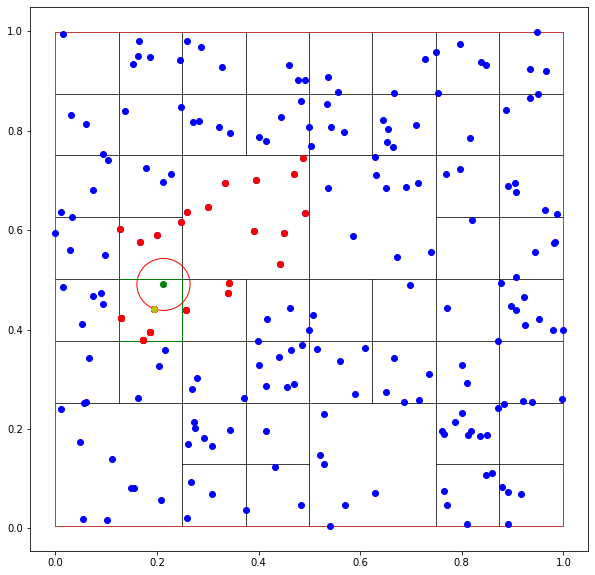

In [404]:
fig, ax = im.CreatePlot(size=(10,10))
PlotQuadtree(ax, quadtree)
ax.plot(pts[:,0], pts[:,1], 'bo')
ax.plot(x[0], x[1], 'go')
PlotRectangle(ax, quadtree.root.aabb, color='r')
for leaf in leaves:
    PlotRectangle(ax, leaf.aabb, color='g', linewidth=1)
# for branch in path:
#     PlotRectangle(ax, branch.aabb, color='y', linewidth=1.2)
PlotCircle(ax, x, min_dist, color='r')
ax.plot(pts_checked[:,0], pts_checked[:,1], 'ro')
ax.plot(closest_pt[0], closest_pt[1], 'yo')

In [9]:
class IM_Sphere:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius
    def ContainsPoint(self, x):
        dx = x - self.center
        return dx.dot(dx) < self.radius**2 

    
def TriangleBoundingSphere(a, b, c):
    AB = b - a
    AC = c - a
    ABAB = AB.dot(AB)
    ACAC = AC.dot(AC)
    ABAC = AB.dot(AC)
    d = ABAB * ACAC - ABAC * ABAC
    p = a
    if d == 0:
        bounds = [np.min(np.array([a,b,c]), axis=0), np.max(np.array([a,b,c]), axis=0)]
        center = (bounds[1] + bounds[0]) / 2
        radius = np.linalg.norm(bounds[1] - bounds[0]) / 2
        return IM_Sphere(center, radius)
    
    s = 0.5 * (ABAB * ACAC - ACAC * ABAC) / d
    t = 0.5 * (ACAC * ABAB - ABAB * ABAC) / d
    if s <= 0:
        center = (a + c) / 2
    elif t <= 0:
        center = (a + b) / 2
    elif s + t >= 1:
        p = b
        center = (b + c) / 2
    else:
        center = a + s * AB + t * AC
    
    radius = np.linalg.norm(center - p)
    return IM_Sphere(center, radius)

In [10]:
class IM_Triangle:
    def __init__(self, ID, verts, indices):
        self.verts = verts
        self.indices = indices 
        self.ID = ID

class IM_Octree:
    def __init__(self, aabb, depth, threshold):
        self.depth = depth
        self.threshold = threshold
        self.root = IM_OctreeNode(aabb, depth, threshold)
    def InsertTriangle(self, tri):
        self.root.InsertTriangle(tri)
        
class IM_OctreeNode:
    def __init__(self, aabb, depth, threshold):
        self.aabb = aabb
        self.depth = depth
        self.threshold = threshold
        self.tris = []
        self.children = []
        self.mark = False
    
    def ContainsPoint(self, pt):
        return self.aabb.ContainsPoint(pt)
    
    def Contains(self, tri):
        return np.any([self.aabb.ContainsPoint(v) for v in tri.verts])
    
    def HasChildren(self):
        return self.children != []
    
    def InsertTriangle(self, tri):
        if self.Contains(tri) == False:
            return
        if self.HasChildren():
            for child in self.children:
                child.InsertTriangle(tri)
        else:
            self.tris.append(tri)
            if self.depth > 0 and self.Size() > self.threshold:
                self.Subdivide()
                for t in self.tris:
                    for node in self.children:
                        node.InsertTriangle(t)
                self.tris = []

    def Subdivide(self):
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    pos = self.aabb.position + np.array([i,j,k]) * self.aabb.size / 2
                    aabb = IM_AABB(pos, self.aabb.size / 2)
                    node = IM_OctreeNode(aabb, self.depth - 1, self.threshold)
                    node.parent = self
                    self.children.append(node)
    
    def Size(self):
        if self.HasChildren() == False:
            return len(self.tris)
        else:
            size = 0
            for child in self.children:
                size += child.Size()
            return size
    
    def NumberOfChildren(self):
        if self.HasChildren() == False:
            return 0
        else:
            size = 0
            for child in self.children:
                size += 1
                size += child.NumberOfChildren()
            return size

In [11]:
def GetAllLeaves(node, leaves):
    if node.HasChildren() == False:
        leaves.append(node)
    else:
        for child in node.children:
            GetLeaves(child, leaves)
            
def GetBranchPathToPoint(nodes_to_process, pt, path):
    if nodes_to_process == []:
        return
    child_nodes_to_process = []
    for node in nodes_to_process:
        path.append(node)
    for node in nodes_to_process:
        if node.HasChildren() == False:
            continue
        for child in node.children:
            if child.ContainsPoint(pt):
                child_nodes_to_process.append(child)
    GetBranchPathToPoint(child_nodes_to_process, pt, path)

def DistanceBoundsPointToNode(pt, node):
    c = node.aabb.position + node.aabb.size / 2
    r = np.sqrt(3) / 2 * np.max(node.aabb.size)
    d = np.linalg.norm(pt - c)
    return [d - r, d + r]

def Unmark(node):
    node.mark = False
    if node.HasChildren() == True:
        for child in node.children:
            Unmark(child)

def Add(node, path):
    path.append(node)
    if node.HasChildren() == True:
        for child in node.children:
            Add(child, path)
            
def GetAllNodes(octree):
    path = []
    Add(octree.root, path)
    return path

def AppendTris(node, tris):
    if node.HasChildren() == True:
        for child in node.children:
            AppendTris(child, tris)
    else:
        for tri in node.tris:
            tris.append(tri.ID)

def GetAllTris(octree):
    tris = []
    AppendTris(octree.root, tris)
    return tris

def NodeClosestTri(node, pt, closest_tri, proj, min_dist):
    if node.mark == True:
        return closest_tri, proj, min_dist
    bounds = DistanceBoundsPointToNode(pt, node)
    if bounds[0] > min_dist:
        return closest_tri, proj, min_dist
    if node.HasChildren() == False:
        if node.tris != []:
            return SearchClosestTri(node.tris, pt)
        else:
            return closest_tri, proj, min_dist
    else:
        for child in node.children:
            ct, p, d = NodeClosestTri(child, pt, closest_tri, proj, min_dist)
            if d < min_dist:
                min_dist = d
                proj = p
                closest_tri = ct
        return closest_tri, proj, min_dist
            
def TriMeshClosestPoint(octree, pt):
    path = []
    GetBranchPathToPoint([octree.root], pt, path)
    min_dist = np.inf
    closest_tri = 0
    proj = (np.array([1,0,0]), pt.copy())
    while len(path) > 0:
        node = path.pop()
        closest_tri, proj, min_dist = NodeClosestTri(node, pt, closest_tri, proj, min_dist)
        node.mark = True
    Unmark(octree.root)
    return closest_tri, proj, min_dist

def SearchClosestTri(tris, pt):
    closest_tri = tris[0].ID
    min_dist = np.inf
    proj = (np.array([1,0,0]), tris[0].verts[0])
    for i in range(len(tris)):
        tri = tris[i].indices
        a = tris[i].verts[0]
        b = tris[i].verts[1]
        c = tris[i].verts[2]
        triproj = im.ProjectPointOntoTriangle(pt,a,b,c)
        dist = np.linalg.norm(triproj[1] - pt)
        if dist < min_dist:
            min_dist = dist
            closest_tri = tris[i].ID
            proj = triproj
    return closest_tri, proj, min_dist

In [29]:
def ComputeTriMeshOctree(trimesh, aabb, depth, threshold):
    octree = IM_Octree(aabb, depth, threshold)
    for i in range(len(trimesh.tris)):
        tri = trimesh.tris[i]
        verts = trimesh.verts[tri]
        octree.InsertTriangle(IM_Triangle(i, verts, tri))
    return octree

def ProjectSampleTriMesh_Octree(fromsample, fromgeom, totopo, octree):
    pts = fromsample.eval(fromgeom)
    xis = np.ndarray([pts.shape[0],2], dtype=float)
    ielems = np.ndarray(pts.shape[0], dtype=int)
    for i in range(len(pts)):
        print("projecting point " + str(i+1) + " / " + str(len(pts)) )
        ielems[i], proj, min_dist = TriMeshClosestPoint(octree, pts[i])
        xis[i] = proj[0][1:3]
    return totopo._sample(ielems, xis)

In [30]:
depth = 5
threshold = 10
aabb = autoplaque_subimg.GetAABB()
aabb = IM_AABB(aabb.ptA, aabb.ptB - aabb.ptA)
octree = ComputeTriMeshOctree(lumen_tri_mesh, aabb, depth, threshold)

In [31]:
n = 100
ielems = np.zeros([n],dtype=int)
xis = np.zeros([n,3],dtype=float)
for i in range(n):
    ielems[i] = np.random.randint(len(gamma_topo))
    xis[i] = np.random.rand(3)

In [32]:
bez = alpha_topo._sample(ielems,xis)
pts = bez.eval(alpha.x)

In [33]:
%%time
b1 = ProjectSampleTriMesh_Octree(bez, alpha.x, gamma_topo, octree)
xvals1 = b1.eval(gamma.x)
print(xvals1)

projecting point 1 / 100
projecting point 2 / 100
projecting point 3 / 100
projecting point 4 / 100
projecting point 5 / 100
projecting point 6 / 100
projecting point 7 / 100
projecting point 8 / 100
projecting point 9 / 100
projecting point 10 / 100
projecting point 11 / 100
projecting point 12 / 100
projecting point 13 / 100
projecting point 14 / 100
projecting point 15 / 100
projecting point 16 / 100
projecting point 17 / 100
projecting point 18 / 100
projecting point 19 / 100
projecting point 20 / 100
projecting point 21 / 100
projecting point 22 / 100
projecting point 23 / 100
projecting point 24 / 100
projecting point 25 / 100
projecting point 26 / 100
projecting point 27 / 100
projecting point 28 / 100
projecting point 29 / 100
projecting point 30 / 100
projecting point 31 / 100
projecting point 32 / 100
projecting point 33 / 100
projecting point 34 / 100
projecting point 35 / 100
projecting point 36 / 100
projecting point 37 / 100
projecting point 38 / 100
projecting point 39 /

In [34]:
%%time
b2 = im.ProjectSampleTriMesh(alpha.x, gamma_topo, gamma.x, bez)
xvals2 = b2.eval(gamma.x)
print(xvals2)

projecting point 1 / 100
617
(array([0, 0, 1]), array([  40.0695794 , -185.0705341 ,  635.22401078]))
projecting point 2 / 100
2161
(array([0, 0, 1]), array([  37.0880253 , -181.22008404,  635.05597261]))
projecting point 3 / 100
2091
(array([0, 0, 1]), array([  37.67454267, -182.36646072,  634.92777043]))
projecting point 4 / 100
525
(array([0, 0, 1]), array([  41.97821906, -190.02361041,  638.07865596]))
projecting point 5 / 100
1418
(array([0, 0, 1]), array([  39.86972809, -184.88671875,  635.47491455]))
projecting point 6 / 100
616
(array([0, 0, 1]), array([  39.97185516, -185.06745911,  635.45037842]))
projecting point 7 / 100
1588
(array([0, 0, 1]), array([  39.59780121, -184.38900757,  635.4710083 ]))
projecting point 8 / 100
2161
(array([0, 0, 1]), array([  37.0880253 , -181.22008404,  635.05597261]))
projecting point 9 / 100
1301
(array([0, 0, 1]), array([  40.37744141, -185.65072632,  635.72766113]))
projecting point 10 / 100
842
(array([0, 0, 1]), array([  41.70745164, -187.

2091
(array([0, 0, 1]), array([  37.67454267, -182.36646072,  634.92777043]))
projecting point 79 / 100
2162
(array([0.87003315, 0.        , 0.12996685]), array([  37.31271417, -181.78783538,  635.12130052]))
projecting point 80 / 100
1139
(array([0, 1, 0]), array([  40.52106476, -185.84741211,  635.47265625]))
projecting point 81 / 100
2091
(array([0, 0, 1]), array([  37.67454267, -182.36646072,  634.92777043]))
projecting point 82 / 100
577
(array([0, 0, 1]), array([  41.88301849, -189.6156311 ,  638.22009277]))
projecting point 83 / 100
2124
(array([0.14794557, 0.        , 0.85205443]), array([  37.38817818, -181.88465299,  635.13807337]))
projecting point 84 / 100
1139
(array([0, 1, 0]), array([  40.52106476, -185.84741211,  635.47265625]))
projecting point 85 / 100
574
(array([0, 0, 1]), array([  42.43580629, -191.1188849 ,  638.10777194]))
projecting point 86 / 100
2099
(array([0, 0, 1]), array([  37.68532399, -182.02077306,  635.29343583]))
projecting point 87 / 100
577
(array([

In [35]:
xvals1 - xvals2

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [36]:
dist1 = np.zeros([n])
for i in range(n):
    dist1[i] = np.linalg.norm(pts[i] - xvals1[i])
print(dist1)

[ 8.55370767  5.38679283  6.46284934  9.12786483  7.77688303  8.4128515
  8.36514402  5.59476262  8.37045464 11.44478898  6.38075243 10.08637661
  9.36206821  7.29626707  7.07761588  7.46430726  8.42042021  7.11493551
  7.12973177  8.18956624  9.22893285  4.31084734  8.33382551  6.61532233
  3.3848965   7.46314096  4.68823563  8.22255927 10.12606527  6.09323364
  6.81502815  8.2767309   7.78975829  9.67054161  9.78401055 10.33929753
  8.33787436  8.33647281  6.62082396 11.63276159  3.71012724  5.59168251
 10.39482075  6.34835148  5.83372971 11.85497072  9.84840733  8.09692558
  5.52047694  6.08442831  3.62764154  6.8593918   4.7634285   5.49710815
  7.06473801  6.27572225  8.90381499  6.16025495  7.82409697 10.23663047
  6.11272028  8.29415633  6.45387283  9.74224324  7.79734746  8.65734158
  6.94739944  5.36543964  9.26718472  8.40309156  9.29408116 10.44805824
  8.66376866 11.46657536  8.35074393  9.23411658  4.522665    7.58016775
  4.90954004 11.22873249  5.05071024  9.03484983  5.

In [37]:
dist2 = np.zeros([n])
for i in range(n):
    dist2[i] = np.linalg.norm(pts[i] - xvals2[i])
print(dist2)

[ 8.55370767  5.38679283  6.46284934  9.12786483  7.77688303  8.4128515
  8.36514402  5.59476262  8.37045464 11.44478898  6.38075243 10.08637661
  9.36206821  7.29626707  7.07761588  7.46430726  8.42042021  7.11493551
  7.12973177  8.18956624  9.22893285  4.31084734  8.33382551  6.61532233
  3.3848965   7.46314096  4.68823563  8.22255927 10.12606527  6.09323364
  6.81502815  8.2767309   7.78975829  9.67054161  9.78401055 10.33929753
  8.33787436  8.33647281  6.62082396 11.63276159  3.71012724  5.59168251
 10.39482075  6.34835148  5.83372971 11.85497072  9.84840733  8.09692558
  5.52047694  6.08442831  3.62764154  6.8593918   4.7634285   5.49710815
  7.06473801  6.27572225  8.90381499  6.16025495  7.82409697 10.23663047
  6.11272028  8.29415633  6.45387283  9.74224324  7.79734746  8.65734158
  6.94739944  5.36543964  9.26718472  8.40309156  9.29408116 10.44805824
  8.66376866 11.46657536  8.35074393  9.23411658  4.522665    7.58016775
  4.90954004 11.22873249  5.05071024  9.03484983  5.

In [38]:
print(dist1-dist2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [22]:
ids = np.unique(GetAllTris(octree))

In [23]:
print(len(ids))
print(len(gamma_topo))

2609
2609


In [24]:
print(len(octree.root.children))

8


In [25]:
for pt in pts:
    print(octree.root.ContainsPoint(pt))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [26]:
print(octree.root.NumberOfChildren())

832


In [27]:
print(octree.root.children)

[<__main__.IM_OctreeNode object at 0x000001B867AEF788>, <__main__.IM_OctreeNode object at 0x000001B867AEF7C8>, <__main__.IM_OctreeNode object at 0x000001B867AEF808>, <__main__.IM_OctreeNode object at 0x000001B867AEF408>, <__main__.IM_OctreeNode object at 0x000001B867AEFA88>, <__main__.IM_OctreeNode object at 0x000001B867AEF488>, <__main__.IM_OctreeNode object at 0x000001B867AEF648>, <__main__.IM_OctreeNode object at 0x000001B867AEF508>]


In [28]:
i1 = 1190
xi1 = [0, 0, 1]
Px1 = [41.87866466, -189.67448816,  638.17758132]
(array([1, 1, 0]), array([  40.52106476, -185.84741211,  635.47265625]))

i2 = 1139
xi2 = [0, 0, 1]
Px2 = [41.87866466, -189.67448816,  638.17758132]
(array([0, 1, 0]), array([  40.52106476, -185.84741211,  635.47265625]))

NameError: name 'array' is not defined

In [29]:
# octree method
print("Triangle " + str(i1) + ":")
tri = lumen_tri_mesh.tris[i1]
verts = lumen_tri_mesh.verts[tri]
print("trimesh verts = ")
print(verts)
select = [False] * (len(gamma_topo))
select[i1] = True
subtopo = im.SelectSubsetTopology(gamma_topo, select)
vert_sample = subtopo.sample('bezier',2)
verts = vert_sample.eval(gamma.x)
print("gamma verts = ")
print(verts)
ielems = np.array([i1],dtype=int)
xis = np.array([xi1[1:3]],dtype=float)
pt_sample = gamma_topo._sample(ielems,xis)
x = pt_sample.eval(gamma.x)
print("xi = " + str(xi1))
print("Px = " + str(Px1))
print("x = " + str(x))

print("---------------------")

# brute force method
print("Triangle " + str(i2) + ":")
tri = lumen_tri_mesh.tris[i2]
verts = lumen_tri_mesh.verts[tri]
print("trimesh verts = ")
print(verts)
select = [False] * (len(gamma_topo))
select[i2] = True
subtopo = im.SelectSubsetTopology(gamma_topo, select)
vert_sample = subtopo.sample('bezier',2)
verts = vert_sample.eval(gamma.x)
print("gamma verts = ")
print(verts)
ielems = np.array([i2],dtype=int)
xis = np.array([xi2[1:3]],dtype=float)
pt_sample = gamma_topo._sample(ielems,xis)
x = pt_sample.eval(gamma.x)
print("xi = " + str(xi2))
print("Px = " + str(Px2))
print("x = " + str(x))

Triangle 578:
trimesh verts = 
[[  41.88707385 -189.61687494  638.09011116]
 [  41.87866466 -189.67448816  638.17758132]
 [  41.89284515 -189.56939697  638.16369629]]
gamma verts = 
[[  41.88707385 -189.61687494  638.09011116]
 [  41.87866466 -189.67448816  638.17758132]
 [  41.89284515 -189.56939697  638.16369629]]
xi = [0, 0, 1]
Px = [41.87866466, -189.67448816, 638.17758132]
x = [[  41.89284515 -189.56939697  638.16369629]]
---------------------
Triangle 577:
trimesh verts = 
[[  41.87866466 -189.67448816  638.17758132]
 [  41.89284515 -189.56939697  638.16369629]
 [  41.88301849 -189.6156311   638.22009277]]
gamma verts = 
[[  41.87866466 -189.67448816  638.17758132]
 [  41.89284515 -189.56939697  638.16369629]
 [  41.88301849 -189.6156311   638.22009277]]
xi = [0, 0, 1]
Px = [41.87866466, -189.67448816, 638.17758132]
x = [[  41.88301849 -189.6156311   638.22009277]]


In [ ]:
# %%time
# bez = alpha_topo.sample('gauss', 1)
# ProjectSampleTriMesh_Octree(bez, alpha.x, gamma_topo, octree)